# [EX7] 네이버 영화리뷰 감성분석 도전하기

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import missingno as msno
from konlpy.tag import Mecab 
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import Word2Vec

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [3]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [5]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2. 데이터로더 구성
가공되지 않은 nsmc 데이터셋을 데이터 전처리

In [6]:
# 리스트 선언
X_train = []
X_test = []
y_train = []
y_test = []

### 1) 데이터의 중복 제거

In [7]:
#document열을 기준으로 중복행 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 

test_data.drop_duplicates(subset=['document'], inplace=True) 
test_data = test_data.dropna(how = 'any') 

In [8]:
# 중복 샘플 제거 확
print('총 샘플의 수 :',len(train_data))
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 146182
총 샘플의 수 : 49157


### 2) NaN 결측치 제거
한글과 공백을 제거 후 결측치 제거

In [9]:
# 한글과 공백을 제외하고 모두 제거
# 한글 범위 참고 : https://www.unicode.org/charts/PDF/UAC00.pdf
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex = True)

In [10]:
# 구두점이나 특수문자를 제거 확인
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [11]:
# train_data에 공백(white space)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "", regex = True)
train_data['document'].replace('', np.nan, inplace = True)

In [12]:
# NuN 값 존재 확인
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [13]:
# NaN 값을 가진 행 출력
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [14]:
# NaN 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(len(train_data)) # 샘플의 개수를 출력하여 샘플이 제거되었는지 확인

145393


<AxesSubplot:>

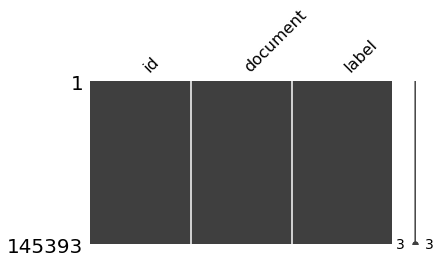

In [15]:
# 결측치 시각화
msno.matrix(train_data, figsize=(6,3))

### 3) 한국어 토크나이저로 토큰화

In [16]:
tokenizer = Mecab() # 토큰화를 위한 형태소 분석기

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### 4) 불용어(Stopwords) 제거
* 불용어 : 의미가 없는 단어나 조사 등

In [17]:
for sentence in train_data['document']:
    temp_X = []
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

for sentence in test_data['document']:
    temp_X = []
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

### 5) 사전 word_to_index 구성
사전(vacab) 크기 설정

* np.concatenate.tolist() : 여러개의 범위 또는 여러개의 텍스트 문자열을 하나의 텍스트 문자열로 연결
* collections 모듈의 Counter 클래스 : 글자 수를 세어주는 함수
* collections 모듈의 most_common 클래스 : 데이터의 개수가 많은 순으로 정렬된 배열을 리턴

In [18]:
vocab_size = 45000
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(vocab_size-4) 

vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

word_to_index = {word:index for index, word in enumerate(vocab)} # 사전의 크기를 결정

In [19]:
# word_to_index 크기 확인
len(word_to_index)

45000

### 6) 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [20]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

## 7) X_train, y_train, X_test, y_test, word_to_index 리턴

In [21]:
# 변환 전 확인
X_train[:2]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']]

In [22]:
# X_train, X_test 에 저장
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

In [23]:
# y_train, y_test 에 target 컬럼 저장
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [24]:
# 변환 후 확인
X_train[:2]

[[27, 67, 895, 33, 214, 15, 28, 699],
 [977, 481, 491, 636, 4, 110, 1554, 48, 864, 949, 11, 38, 364]]

In [25]:
# word_to_index 
index_to_word = {index:word for word, index in word_to_index.items()}

In [26]:
# index_to_word 확인
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '적',
 22: '안',
 23: '정말',
 24: '로',
 25: '것',
 26: '음',
 27: '아',
 28: '네요',
 29: '어',
 30: '재밌',
 31: '지만',
 32: '같',
 33: '진짜',
 34: '에서',
 35: '했',
 36: '기',
 37: '네',
 38: '않',
 39: '점',
 40: '거',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: 'ㅋㅋ',
 46: '인',
 47: '말',
 48: '연기',
 49: '주',
 50: '최고',
 51: '내',
 52: '평점',
 53: '이런',
 54: '던',
 55: '어요',
 56: '할',
 57: '왜',
 58: '겠',
 59: '스토리',
 60: '해',
 61: 'ㅋㅋㅋ',
 62: '습니다',
 63: '듯',
 64: '아니',
 65: '드라마',
 66: '생각',
 67: '더',
 68: '그',
 69: '싶',
 70: '사람',
 71: '때',
 72: '감동',
 73: '배우',
 74: '함',
 75: '본',
 76: '까지',
 77: '뭐',
 78: '알',
 79: '만들',
 80: '내용',
 81: '볼',
 82: '보다',
 83: '감독',
 84: '라',
 85: '재미',
 86: '그냥',
 87: '시간',
 88: '지루',
 89: '중',
 90: '재미있',
 91: '였',
 92: '잼',
 93: '년',
 94: '사랑',
 

In [27]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 함
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

### 1) 데이터셋 내 문장 길이 분포

In [28]:
# 데이터 실제 예시 확인
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[27, 67, 895, 33, 214, 15, 28, 699]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13


In [29]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.33899768696993
문장길이 최대 :  105
문장길이 표준편차 :  11.861020004684411


### 2) 적절한 최대 문장 길이 지정   

리뷰의 최대 길이 : 105
리뷰의 평균 길이 : 14.33899768696993


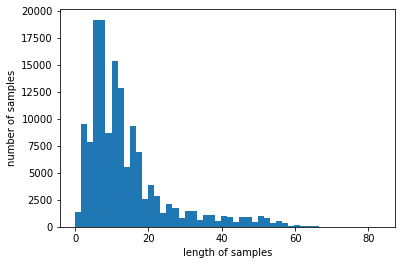

In [30]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
# 예를들어, 최대 길이를 (평균 + 2 * 표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 가 maxlen 설정값 이내에 포함된다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  38
전체 문장의 0.9364019532253919% 가 maxlen 설정값 이내에 포함된다. 


### 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 
padding 방식을  앞쪽('pre') 으로 설정하여 문장의 길이 맞추기

In [32]:
# padding 전 타입 확인
type(X_train)

list

In [33]:
maxlen = 30

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [34]:
# padding 후 타입 확인
type(X_train)

numpy.ndarray

In [35]:
# padding 후 쉐잎 확인
print(X_train.shape)
print(X_train.shape)

(145393, 30)
(145393, 30)


## 4. 모델구성 및 validation set 구성

### 1) 모델구성
LSTM은 기존 RNN을 개선한 모델로 긴 의존 기간(long-term dependency)을     
필요로 하는 데이터를 학습하는데 효과적인 모델로 리뷰 분류에 적합

In [36]:
vocab_size = 45000
word_vector_dim = 200

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model= keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16)) # LSTM 임베딩 벡터의 차원
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         9000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 9,014,033
Trainable params: 9,014,033
Non-trainable params: 0
_________________________________________________________________


### 2) validation set 구성
훈련 데이터 중 20%를 검증 데이터로 사용

In [37]:
print(X_train.shape)
print(X_train.shape)

(145393, 30)
(145393, 30)


In [38]:
# validation set 10000건 분리
X_val = X_train[:29000]   
y_val = y_train[:29000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[29000:]  
partial_y_train = y_train[29000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116393, 30)
(116393,)


## 5. 모델 훈련 개시

In [39]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4048,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
29/29 [==============================] - 7s 150ms/step - loss: 0.6741 - accuracy: 0.6591 - val_loss: 0.5424 - val_accuracy: 0.7896
Epoch 2/15
29/29 [==============================] - 3s 116ms/step - loss: 0.4739 - accuracy: 0.8156 - val_loss: 0.3763 - val_accuracy: 0.8390
Epoch 3/15
29/29 [==============================] - 3s 113ms/step - loss: 0.3380 - accuracy: 0.8628 - val_loss: 0.3577 - val_accuracy: 0.8458
Epoch 4/15
29/29 [==============================] - 3s 114ms/step - loss: 0.2910 - accuracy: 0.8868 - val_loss: 0.3607 - val_accuracy: 0.8442
Epoch 5/15
29/29 [==============================] - 3s 114ms/step - loss: 0.2646 - accuracy: 0.8990 - val_loss: 0.3719 - val_accuracy: 0.8429
Epoch 6/15
29/29 [==============================] - 3s 112ms/step - loss: 0.2417 - accuracy: 0.9107 - val_loss: 0.3858 - val_accuracy: 0.8408
Epoch 7/15
29/29 [==============================] - 3s 113ms/step - loss: 0.2247 - accuracy: 0.9176 - val_loss: 0.3959 - val_accuracy: 0.8390
Epoch 

In [40]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5544 - accuracy: 0.8128
[0.5543965697288513, 0.8128241896629333]


## 6. Loss, Accuracy 그래프 시각화
history 변수를 이용하여 그래프 시각화

In [41]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Training and validation loss 그래프 시각화를 통해, epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있음       
validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미

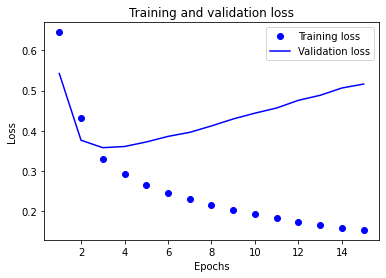

In [42]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs') # 파란 점
plt.ylabel('Loss') # 파란 실선
plt.legend()

plt.show()

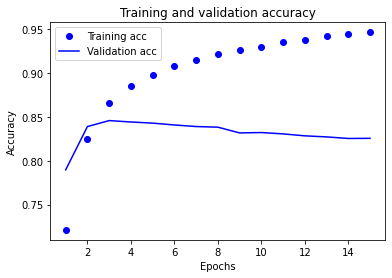

In [43]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs') # 파란 점
plt.ylabel('Accuracy') # 파란 실선
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [44]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(45000, 200)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
https://github.com/Kyubyong/wordvectors 에서 한국어 Word2Vec 단어 벡터 다운로드

In [46]:
from gensim.models import Word2Vec
import os

# 한국어 Word2Vec 사용
word2vec_ko_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec_ko = Word2Vec.load(word2vec_ko_path)

print(word2vec_ko)

Word2Vec(vocab=30185, size=200, alpha=0.025)


In [47]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec_ko:
        embedding_matrix[i] = word2vec_ko[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### 1) CNN 모델 인베딩 벡터 적용

In [48]:
vocab_size = 45000  # 어휘 사전의 크기
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_CNN.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         9000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 9,014,033
Trainable params: 9,014,033
Non-trainable params: 0
_________________________________________________________________


### 2) LSTM 모델에 인베딩 벡터 적용

In [49]:
vocab_size = 45000  # 어휘 사전의 크기
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                   word_vector_dim, 
                   embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen, 
                   trainable=True))
model_LSTM.add(keras.layers.LSTM(164))
model_LSTM.add(keras.layers.Dense(64, activation='relu')) 
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 200)           9000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 164)               239440    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                10560     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,250,065
Trainable params: 9,250,065
Non-trainable params: 0
_________________________________________________________________


### 3) GlobalMaxPooling1D() 에 임베딩 벡터 적용

In [50]:
vocab_size = 45000  # 어휘 사전의 크기
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model_GMP = keras.Sequential()
model_GMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(keras.layers.GlobalMaxPooling1D())
model_GMP.add(keras.layers.Dense(32, activation='relu'))
model_GMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         9000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 9,006,465
Trainable params: 9,006,465
Non-trainable params: 0
_________________________________________________________________


### 4) 각 모델 학습

In [51]:
# CNN 모델
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model_CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4086,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
29/29 [==============================] - 10s 247ms/step - loss: 0.6996 - accuracy: 0.5203 - val_loss: 0.6699 - val_accuracy: 0.6091
Epoch 2/10
29/29 [==============================] - 4s 130ms/step - loss: 0.6496 - accuracy: 0.6338 - val_loss: 0.5896 - val_accuracy: 0.6895
Epoch 3/10
29/29 [==============================] - 4s 129ms/step - loss: 0.5652 - accuracy: 0.7121 - val_loss: 0.5236 - val_accuracy: 0.7394
Epoch 4/10
29/29 [==============================] - 4s 127ms/step - loss: 0.4984 - accuracy: 0.7607 - val_loss: 0.4858 - val_accuracy: 0.7650
Epoch 5/10
29/29 [==============================] - 4s 127ms/step - loss: 0.4530 - accuracy: 0.7907 - val_loss: 0.4541 - val_accuracy: 0.7879
Epoch 6/10
29/29 [==============================] - 4s 128ms/step - loss: 0.4135 - accuracy: 0.8151 - val_loss: 0.4370 - val_accuracy: 0.7976
Epoch 7/10
29/29 [==============================] - 4s 127ms/step - loss: 0.3844 - accuracy: 0.8302 - val_loss: 0.4222 - val_accuracy: 0.8071
Epoch

In [52]:
# LSTM 모델
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs =  

history = model_LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4086,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
29/29 [==============================] - 10s 280ms/step - loss: 0.6231 - accuracy: 0.6424 - val_loss: 0.5118 - val_accuracy: 0.7456
Epoch 2/10
29/29 [==============================] - 7s 256ms/step - loss: 0.4802 - accuracy: 0.7694 - val_loss: 0.4301 - val_accuracy: 0.7981
Epoch 3/10
29/29 [==============================] - 7s 258ms/step - loss: 0.4040 - accuracy: 0.8169 - val_loss: 0.3824 - val_accuracy: 0.8260
Epoch 4/10
29/29 [==============================] - 7s 255ms/step - loss: 0.3511 - accuracy: 0.8459 - val_loss: 0.3590 - val_accuracy: 0.8406
Epoch 5/10
29/29 [==============================] - 7s 255ms/step - loss: 0.3151 - accuracy: 0.8664 - val_loss: 0.3554 - val_accuracy: 0.8435
Epoch 6/10
29/29 [==============================] - 7s 255ms/step - loss: 0.2788 - accuracy: 0.8858 - val_loss: 0.3460 - val_accuracy: 0.8498
Epoch 7/10
29/29 [==============================] - 7s 257ms/step - loss: 0.2516 - accuracy: 0.8987 - val_loss: 0.3553 - val_accuracy: 0.8507
Epoch

In [53]:
# GlobalMaxPooling1D 모델
model_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model_GMP.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=2086,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
56/56 [==============================] - 5s 74ms/step - loss: 0.6705 - accuracy: 0.6845 - val_loss: 0.4891 - val_accuracy: 0.8227
Epoch 2/10
56/56 [==============================] - 4s 70ms/step - loss: 0.4211 - accuracy: 0.8388 - val_loss: 0.3530 - val_accuracy: 0.8443
Epoch 3/10
56/56 [==============================] - 4s 71ms/step - loss: 0.2998 - accuracy: 0.8780 - val_loss: 0.3419 - val_accuracy: 0.8510
Epoch 4/10
56/56 [==============================] - 4s 70ms/step - loss: 0.2449 - accuracy: 0.9046 - val_loss: 0.3460 - val_accuracy: 0.8523
Epoch 5/10
56/56 [==============================] - 4s 70ms/step - loss: 0.1990 - accuracy: 0.9271 - val_loss: 0.3586 - val_accuracy: 0.8498
Epoch 6/10
56/56 [==============================] - 4s 69ms/step - loss: 0.1578 - accuracy: 0.9457 - val_loss: 0.3779 - val_accuracy: 0.8481
Epoch 7/10
56/56 [==============================] - 4s 70ms/step - loss: 0.1218 - accuracy: 0.9621 - val_loss: 0.4033 - val_accuracy: 0.8453
Epoch 8/10
56

### 5) 테스트셋을 이용한 모델 평가

In [54]:
# CNN 모델
results = model_CNN.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.4221 - accuracy: 0.8126
[0.4220803678035736, 0.8125801086425781]


In [55]:
# LSTM 모델
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.4402 - accuracy: 0.8320
[0.44017454981803894, 0.8320483565330505]


In [56]:
# GlobalMaxPooling1D 모델
results = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5007 - accuracy: 0.8330
[0.500729501247406, 0.8330451250076294]


## 9. 결과 및 회고

#### * 결과
    * cnn 모델 : accuracy -> 0.8126
    * LSTM 모델 : accuracy -> 0.8320
    * GlobalMaxPooling1D 모델 : accuracy -> 0.8330

#### * 회고
모델 accuracy 값이 0.85 이상의 점수가 나오지 않아 0.83~4에서 최종 마무리하였다.     
다양한 전처리 방법과, 모델 그래프 시각화를 통한 하이퍼 파라미터 적용 방법을 찾아봐야겠다.    
[참고] https://wikidocs.net/44249